In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
import torch
from torch_geometric.data import Data, DataLoader
from torch.nn.functional import softmax, relu
from torch_geometric.nn import dense_diff_pool
from torch import Tensor
from typing import Tuple

from torch_geometric.utils import to_networkx, negative_sampling
import networkx as nx

In [4]:
import utils.torchUtils as gnn
from utils.torchUtils.cpp_geometric import layers

In [5]:
dout='knn'

In [6]:
gnn.config.set_gpu(False)

In [7]:
def mask_graph(data, edge_mask):
    data = data.clone()
    data.edge_index = data.edge_index[:,edge_mask]
    data.edge_attr = data.edge_attr[edge_mask]
    return data

In [28]:
def sample_center(data, center):
    edge_mask = (data.edge_index == center).any(dim=0)
    if hasattr(data, 'edge_mask'):
        edge_mask = edge_mask & data.edge_mask
    return edge_mask

class RandomSample(gnn.BaseTransform):
    def __call__(self, data : Data) -> Data:
        true_nodes = torch.where(data.y)[0]
        center = true_nodes[torch.randint(true_nodes.shape[0], (1,))]
        edge_mask = sample_center(data, center)
        data.edge_index = data.edge_index[:,edge_mask]
        data.edge_attr  = data.edge_attr[edge_mask]
        data.edge_y     = data.edge_y[edge_mask]
        data.edge_id    = data.edge_id[edge_mask]
        return data

In [30]:
import utils.torchUtils as gnn 

# min_edge = gnn.min_edge_neighbor(n_neighbor=2, function=lambda f:f**2)
min_edge = gnn.min_edge_neighbor(n_neighbor=2)

# transform = None
transform = gnn.Transform(min_edge)
# transform.append(RandomSample())
template = gnn.Dataset('../data/template',make_template=True, transform=transform)

def load_dataset(fn='../data/MX_1200_MY_500-training', template=None, shuffle=False):
    dataset = gnn.Dataset(fn,transform=template.transform)
    training = dataset[:3000]
    testing = dataset[3000:6000]
    validation = dataset[6000:9000]
    # training, testing = gnn.train_test_split(dataset[:9000], 0.33)
    # training, validation = gnn.train_test_split(training, 0.5)

    batch_size = 100
    trainloader = DataLoader(training, batch_size=batch_size, shuffle=shuffle, num_workers=gnn.config.ncpu)
    validloader = DataLoader(validation, batch_size=batch_size, shuffle=shuffle, num_workers=gnn.config.ncpu)
    testloader = DataLoader(testing, batch_size=batch_size, shuffle=shuffle, num_workers=gnn.config.ncpu)

    return trainloader, validloader, testloader

trainloader, validloader, testloader = load_dataset(template=template)

In [31]:
data = next( data for data in testloader.dataset if data.y.sum() == 8 and data.num_nodes == 10 )

In [68]:
def draw_data(data, edge_mask=None, width=None, figax=None, edge_labels=None, **kwargs):
    if figax is None: figax = plt.subplots()
    fig, ax = figax
    plt.sca(ax)

    # if width is not None:
    #     width = gnn.attr_undirected(data.edge_index, width)

    self_edges = data.edge_index[0] == data.edge_index[1]

    if edge_mask is None: edge_mask = ~self_edges
    edge_mask = edge_mask & (~self_edges)

    # edge_mask = mask_undirected(data, edge_mask)
    data = mask_graph(data, edge_mask)
    if width is not None:
        width = width[edge_mask]
    
    # if width is not None:
    #     width = width[data.edge_index[0]<data.edge_index[1]]

    for key, value in kwargs.items():
        if value.shape[0] == edge_mask.shape[0]:
            kwargs[key] = value[edge_mask].numpy()


    graph = to_networkx(data, remove_self_loops=True, )

    pos = nx.circular_layout(graph)

    nx.draw(graph, pos, node_color=(data.node_id+1)//2, width=width, **kwargs)

    if edge_labels is not None:
        edge_labels = edge_labels[edge_mask]
        edge_labels = dict([( ( int(n1), int(n2)), int(label)) for (n1,n2),label in zip(data.edge_index.T, edge_labels)])
        nx.draw_networkx_edge_labels(graph, pos, edge_labels)

    return fig, ax

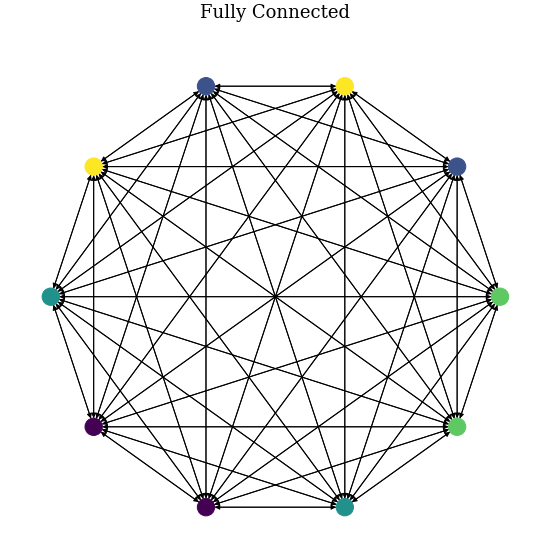

In [59]:
fig,ax=plt.subplots(figsize=(8,8))
draw_data(data,figax=(fig,ax))
fig.suptitle('Fully Connected')
fig.tight_layout()
study.save_fig(fig, dout, 'fully_connected')

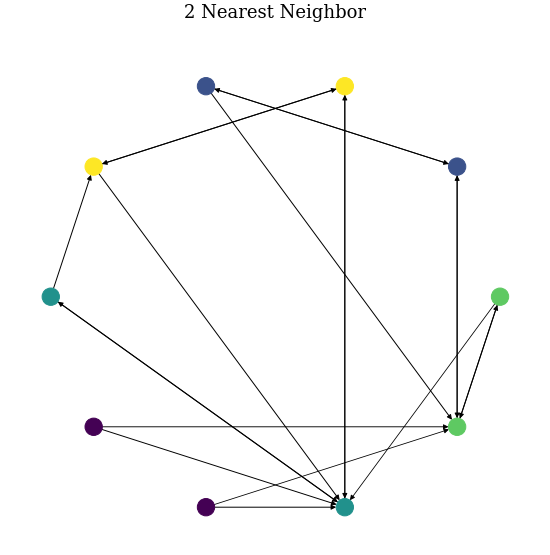

In [55]:
fig,ax=plt.subplots(figsize=(8,8))
draw_data(data, edge_mask=data.edge_mask, width=torch.exp(-data.edge_d), figax=(fig,ax))
fig.suptitle('2 Nearest Neighbor')
fig.tight_layout()
study.save_fig(fig, dout, '2nn_connected')

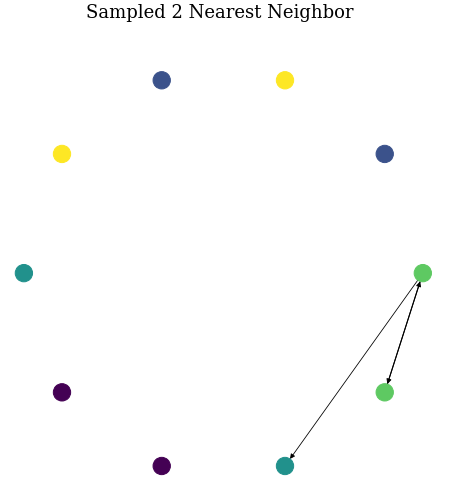

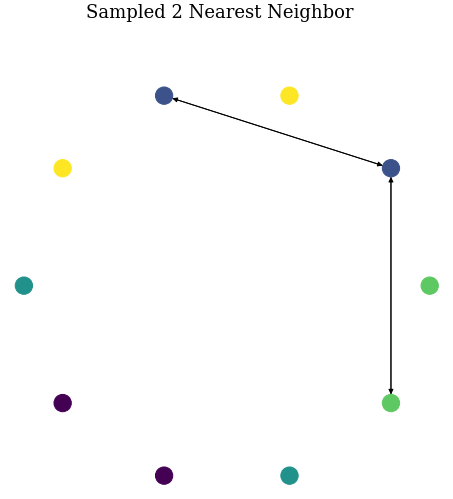

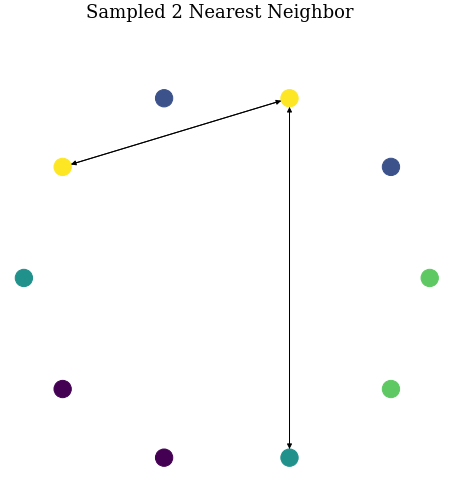

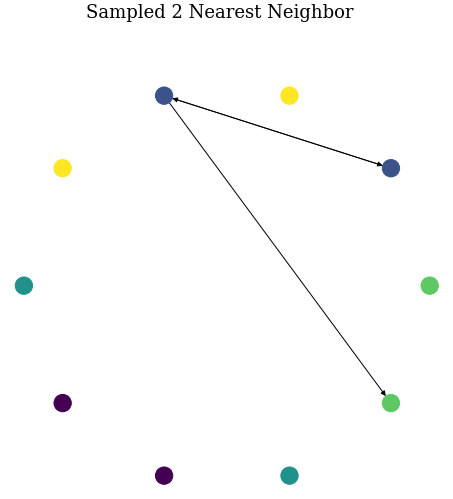

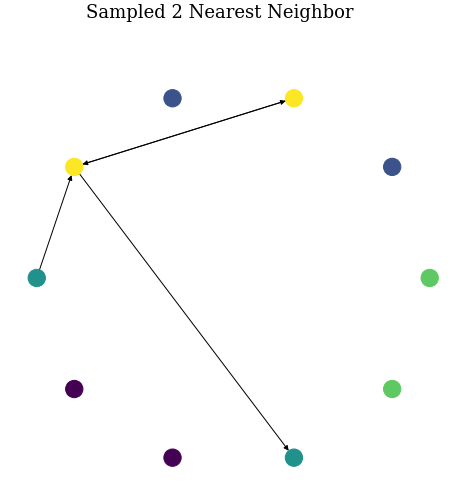

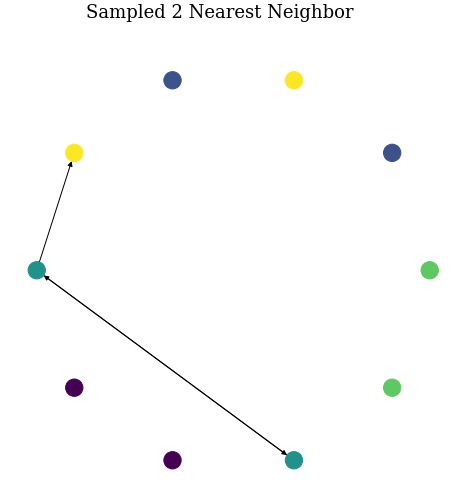

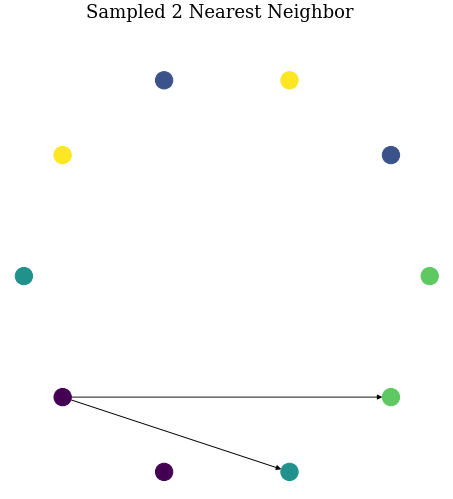

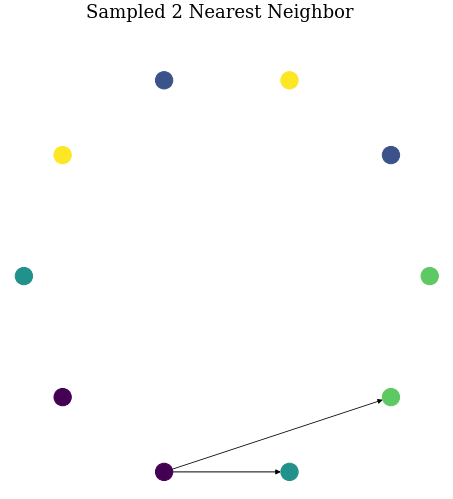

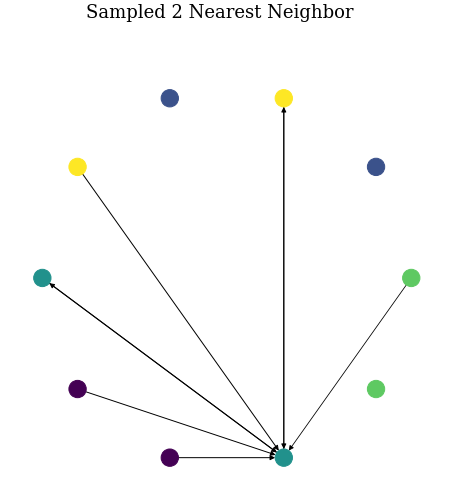

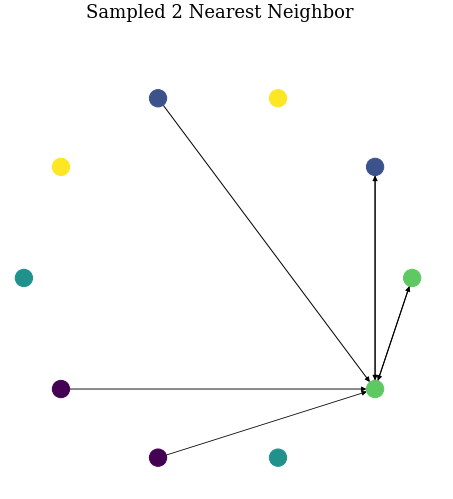

In [44]:
for i in range(data.num_nodes):
    fig,ax=plt.subplots(figsize=(8,8))
    fig.suptitle('Sampled 2 Nearest Neighbor')
    edge_mask = sample_center(data, i)
    draw_data(data, edge_mask=edge_mask, width=torch.exp(-data.edge_d), figax=(fig,ax))
    study.save_fig(fig,dout,f'{i}_2nn_connected')

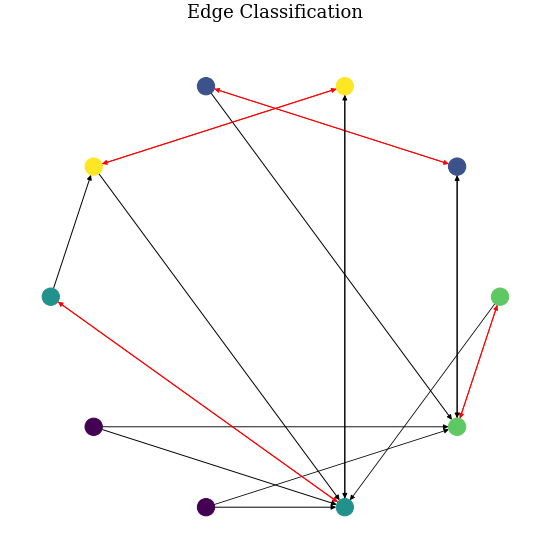

In [78]:
fig,ax=plt.subplots(figsize=(8,8))

edge_color = torch.Tensor([ (1,0,0) if y else (0,0,0) for y in data.edge_y ])

draw_data(data, edge_mask=data.edge_mask, width=torch.exp(-data.edge_d), edge_color=edge_color, figax=(fig,ax))
fig.suptitle('Edge Classification')
fig.tight_layout()
study.save_fig(fig, dout, 'colored_2nn_connected')

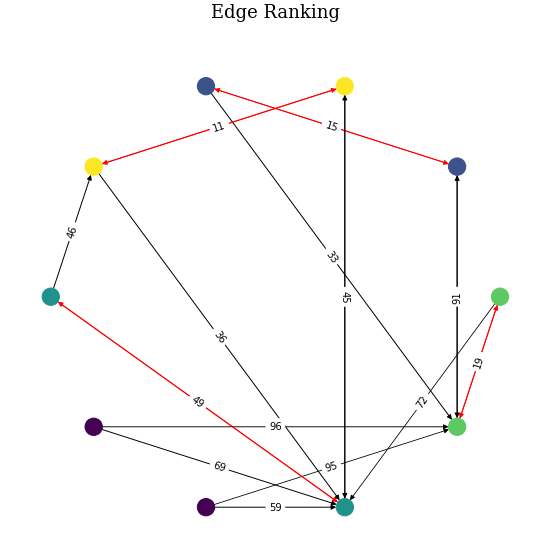

In [79]:
fig,ax=plt.subplots(figsize=(8,8))

edge_color = torch.Tensor([ (1,0,0) if y else (0,0,0) for y in data.edge_y ])
edge_labels = torch.argsort(torch.exp(-data.edge_d))

draw_data(data, edge_mask=data.edge_mask, width=torch.exp(-data.edge_d), edge_color=edge_color, edge_labels=edge_labels, figax=(fig,ax))
fig.suptitle('Edge Ranking')
fig.tight_layout()
study.save_fig(fig, dout, 'ranked_2nn_connected')